# CNN to detect COVID in chest x-rays

We model a convolutional neural network (CNN) to distinguish between normal and COVID-19 chest x-rays images. 

<p align="center"><img src="https://specials-images.forbesimg.com/imageserve/5fc3d7e77159da32978948e1/960x0.jpg?cropX1=629&cropX2=4901&cropY1=0&cropY2=3264" width="40%"></p>

The use of artificial intelligence to assist medical teams in diagnosing diseases is each day more common. In the COVID-19 pandemics, exams such as chest x-rays and ct-scans, are typically used to distinguish between normal and SARS-COV-2 virus infections. Compared to healthy cases, covid affected lungs display the so-called Ground glass opacities: lighter-colored, gray patches, rather than black regions, that appear on the radiography. 

While it is always important to rely on medical expertise for any decision making, machine learning tools can add fast and reliable means to improve the process.        

Our work aims to contribute in this scenario, providing machine learning gears to help with the diagnostic.       

To train the CNN model we used a public available dataset from [1-2]. The balanced set contained 3616 samples of each category. 70% of them were use for training the NN and 30% for validation. 

This script is inspired on the material available on [3].

> [1] M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676. https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

> [2] Rahman, T., Khandakar, A., Qiblawey, Y., Tahir, A., Kiranyaz, S., Kashem, S.B.A., Islam, M.T., Maadeed, S.A., Zughaier, S.M., Khan, M.S. and Chowdhury, M.E., 2020. Exploring the Effect of Image Enhancement Techniques on COVID-19 Detection using Chest X-ray Images.

> [3] https://pythonprogramming.net/introduction-deep-learning-python-tensorflow-keras/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os as os
import cv2
from tqdm import tqdm
import random
import pickle



In [2]:
CATEGORIES = ["COVID", "Normal"]
DATADIR = os.getcwd()


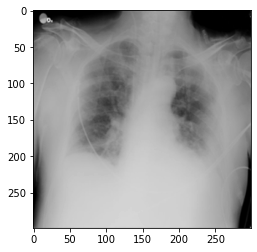

In [28]:
for category in CATEGORIES:  # go through covid and normal images
    path = os.path.join(DATADIR,category)  # create path to covid and normal images
    for img in os.listdir(path):  # iterate over each image per image
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # let's see one of them
        plt.show()  # display!

        break  # just one for now, so break
    break  

In [61]:
print(img_array.shape) # what is the typical image size 


(299, 299)


In [62]:
IMG_SIZE = 100 #better to use smaller ones

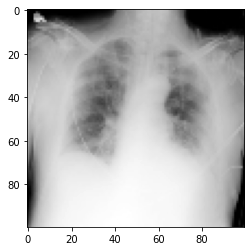

In [63]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show() # see if its still good

In [32]:
# let's load the images
training_data = []

num_covid = len(os.listdir(os.path.join(DATADIR,'COVID')))

def create_training_data():
    for category in CATEGORIES:  # do covid and normal

        path = os.path.join(DATADIR,category)  # create path to covid and normal
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=covid  1=normal

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                if (len(training_data)>2*num_covid): # keep the set balanced 
                    print('fim')
                    break 
            except Exception as e:  # in the interest in keeping the output clean...
                pass

In [33]:
create_training_data()

print(len(training_data))

 35%|███▌      | 3616/10192 [00:16<00:30, 214.19it/s]

fim
7233


In [34]:
random.shuffle(training_data) #shuffle the data

In [35]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = X/255.0

y = np.array(y)

In [36]:
sum(y==0)

3616

In [37]:
pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [22]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [23]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import time

In [24]:
NAME = "Covid-vs-Normal-CNN"

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [64]:

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

history = model.fit(X, y,
          batch_size=32,
          epochs=15,
          validation_split=0.7,
          callbacks=[tensorboard])

Epoch 1/15
68/68 [==============================] - 22s 321ms/step - loss: 0.6138 - accuracy: 0.6515 - val_loss: 0.5579 - val_accuracy: 0.7162
Epoch 2/15
68/68 [==============================] - 20s 294ms/step - loss: 0.4434 - accuracy: 0.7888 - val_loss: 0.4146 - val_accuracy: 0.8075
Epoch 3/15
68/68 [==============================] - 22s 332ms/step - loss: 0.3675 - accuracy: 0.8446 - val_loss: 0.3571 - val_accuracy: 0.8406
Epoch 4/15
68/68 [==============================] - 19s 278ms/step - loss: 0.3324 - accuracy: 0.8557 - val_loss: 0.3407 - val_accuracy: 0.8622
Epoch 5/15
68/68 [==============================] - 21s 306ms/step - loss: 0.3033 - accuracy: 0.8691 - val_loss: 0.3119 - val_accuracy: 0.8756
Epoch 6/15
68/68 [==============================] - 18s 269ms/step - loss: 0.3065 - accuracy: 0.8741 - val_loss: 0.3224 - val_accuracy: 0.8645
Epoch 7/15
68/68 [==============================] - 19s 288ms/step - loss: 0.2399 - accuracy: 0.9027 - val_loss: 0.2846 - val_accuracy: 0.8977

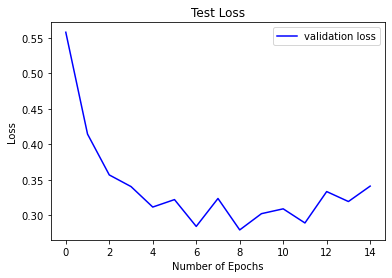

In [65]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Saving the Model

In [40]:
model.save('newtest.model')

INFO:tensorflow:Assets written to: newtest.model\assets


## Testing the Model

In [41]:
def prepare(filepath):
#    IMG_SIZE = 128  
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read in the image and convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image 
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # return the image with shaping that TF wants.


In [58]:
file = 'healthy-chest-x-ray-zephyrscience-photo-library.jpg'


In [59]:
prediction = model.predict([prepare(file)])  # REMEMBER YOU'RE PASSING A LIST OF THINGS YOU WISH TO PREDICT


In [60]:
print(CATEGORIES[int(prediction[0][0])])


Normal
